In [98]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.optimize import curve_fit
from scipy.stats import norm, gamma
from scipy import signal

import statsmodels.api as sm
import statsmodels.tsa as tsa


import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

## Cross Spectrum Analysis
#### looking for periodicities in these two timeseries and relationships between the two timeseries that will be revealed by cross-spectral analysis

In [99]:
# load data
fpath = '' # same as current folder
file = 'HW6Spectral_2020.mat'
mat_file = sio.loadmat(fpath + file)
del mat_file['__header__']
del mat_file['__version__']
del mat_file['__globals__']
print(mat_file.keys())
mat_file

dict_keys(['x552csp', 'y552csp'])


{'x552csp': array([[-1.11378269],
        [-9.38319819],
        [-8.45840232],
        ...,
        [11.67120146],
        [-2.25360324],
        [ 4.09651434]]),
 'y552csp': array([[ -2.04318497],
        [  4.37527431],
        [  3.66378498],
        ...,
        [-13.85737401],
        [-14.30147476],
        [-16.23494884]])}

In [100]:
# create variables for
x_unadj = mat_file['x552csp'].squeeze() # 365.25 days * 16 yrs
y_unadj = mat_file['y552csp'].squeeze() # 365.25 days * 16 yrs

x = x_unadj.copy()
y = y_unadj.copy()
x += -x.mean() # remove mean (i think i need to do this?)
y += -y.mean()

ndays = len(x)
ndpery = 365.25
nyears = len(x)/ndpery
t = np.arange(0,ndays) # time values of 0 to ndays

Text(0.5, 1.0, 'x time series (unadjusted)')

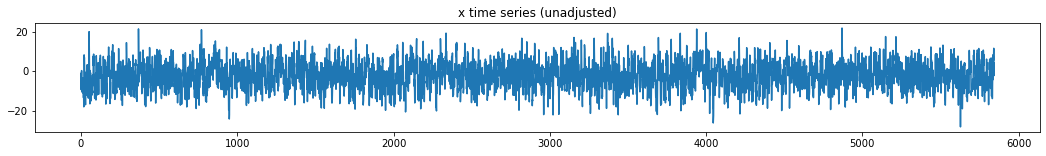

In [190]:
plt.subplots(figsize=(18,2))
plt.plot(x_unadj)
plt.title('x time series (unadjusted)')

Text(0.5, 1.0, 'y time series (unadjusted)')

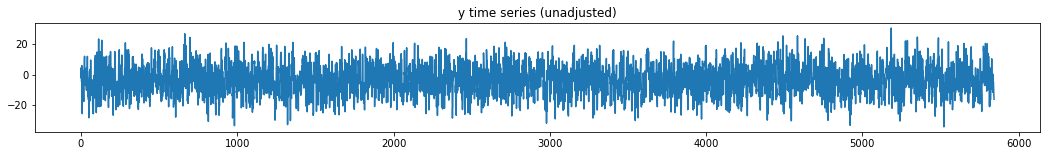

In [191]:
plt.subplots(figsize=(18,2))
plt.plot(y_unadj)
plt.title('y time series (unadjusted)')

(0, 730)

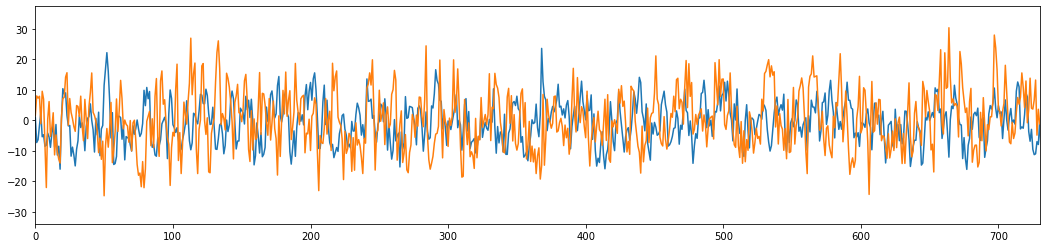

In [102]:
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(x)
plt.plot(y)
plt.xlim(0,365*2)

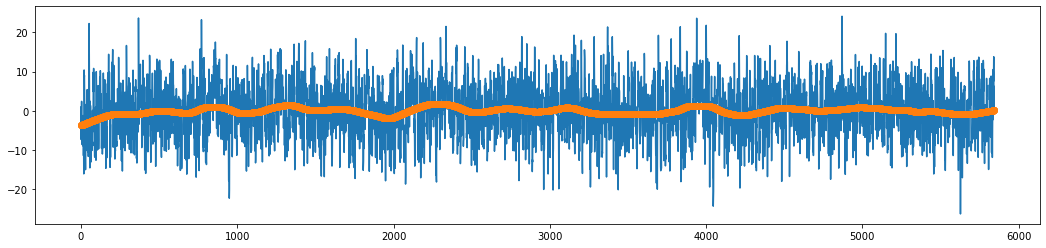

In [103]:
# attempt at lowess regression to assess annual cycle
lowess = sm.nonparametric.lowess
z = lowess(x,t,frac=1/16,return_sorted=False)

fig, ax = plt.subplots(figsize=(18,4))
plt.plot(x)
plt.plot(z,marker='o')

In [104]:
# check for linear trend in data
xreg = stats.linregress(t,x)
yreg = stats.linregress(t,y)
print(xreg) # x-value does not have sig trend
print(yreg) # y-value has a significant trend

LinregressResult(slope=4.9930126682384395e-05, intercept=-0.14587086510258584, rvalue=0.012424654113090905, pvalue=0.34229047014190706, stderr=5.257315738583469e-05)
LinregressResult(slope=0.00016050001773580075, intercept=-0.4689008018151418, rvalue=0.028628452985233116, pvalue=0.028632270642650864, stderr=7.331931244657884e-05)


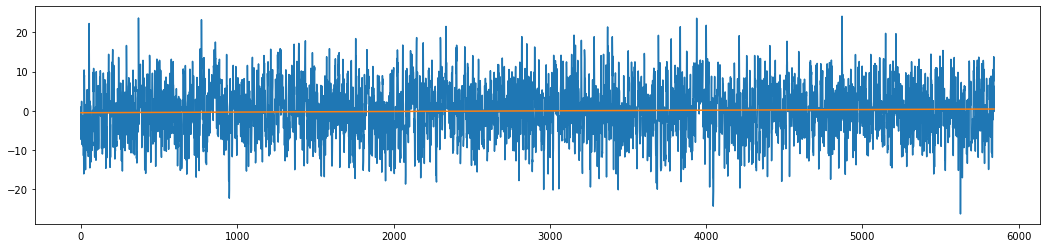

In [105]:
temp = yreg.intercept+yreg.slope*t
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(x)
plt.plot(temp)#,marker='o')

In [106]:
ff = np.fft.fft(x,n=128)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


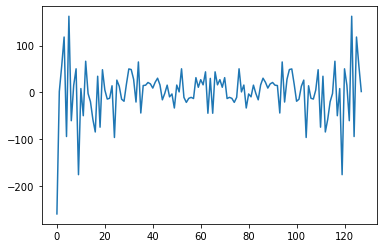

In [107]:
plt.plot(ff)

In [108]:
x[0::365]

array([ 0.98589313, -2.41692171, -0.20566529,  1.54986811, -8.94442439,
        5.51256349, 17.32031887,  7.69529095, -3.61413651, 14.59018782,
       -6.06402454,  6.38185963,  8.74820232,  9.20760962,  2.86881238,
       -0.68415474,  9.53973971])

In [109]:
x.mean()

1.5562879907134295e-16

## Remove annual cycle

In [110]:
# create periodic series for regression against first n harmonics
n = 6
harmonic = {}
t = np.arange(1,ndays+1)

# mean harmonic
harmonic['0'] = np.zeros(ndays)+1

for j in range(1,n//2+1):
    i = 2*j-1
    k = 2*j
    harmonic['{0}'.format(i)] = np.cos(j*2*np.pi/ndpery*t)
    harmonic['{0}'.format(k)] = np.sin(j*2*np.pi/ndpery*t)
harmonic

{'0': array([1., 1., 1., ..., 1., 1., 1.]),
 '1': array([0.99985204, 0.99940821, 0.99866864, ..., 0.99940821, 0.99985204,
        1.        ]),
 '2': array([ 1.72015754e-02,  3.43980606e-02,  5.15843669e-02, ...,
        -3.43980606e-02, -1.72015754e-02, -3.91886976e-15]),
 '3': array([0.99940821, 0.99763355, 0.99467811, ..., 0.99763355, 0.99940821,
        1.        ]),
 '4': array([ 3.43980606e-02,  6.87554085e-02,  1.03031379e-01, ...,
        -6.87554085e-02, -3.43980606e-02, -7.83773951e-15]),
 '5': array([0.99866864, 0.99467811, 0.98803902, ..., 0.99467811, 0.99866864,
        1.        ]),
 '6': array([ 5.15843669e-02,  1.03031379e-01,  1.54204048e-01, ...,
        -1.03031379e-01, -5.15843669e-02, -1.17566093e-14])}

In [111]:
# this creates a matrix for regression of the harmonics
harmonic_matrix = np.zeros(ndays*len(harmonic)).reshape(len(harmonic),ndays)
for i,key in enumerate(harmonic):
    harmonic_matrix[i,:] = harmonic[key]

In [112]:
# Cmat contains amplitudes of harmonics
Cmat_x = np.matmul(harmonic_matrix,x/ndays)
Cmat_y = np.matmul(harmonic_matrix,y/ndays)
print(Cmat_x.shape)
Cmat_y

(7,)


array([ 8.32667268e-17,  1.10471983e-01, -1.28152259e-01,  2.79701262e-02,
       -1.25129913e-01, -6.12919117e-02, -1.49016610e-01])

In [113]:
# fitted annual cycle
fitcycle_x = np.matmul(Cmat_x,harmonic_matrix)
fitcycle_y = np.matmul(Cmat_y,harmonic_matrix)
x_norm = x - fitcycle_x # subtracts cycle from x
y_norm = y - fitcycle_y # subtracts cycle from x

Text(0, 0.5, 'Value')

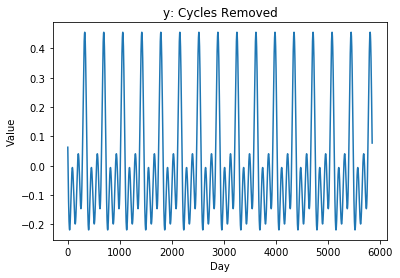

In [114]:
plt.plot(fitcycle_y)
plt.title('y: Cycles Removed')
plt.xlabel('Day')
plt.ylabel('Value')

Text(0, 0.5, 'Value')

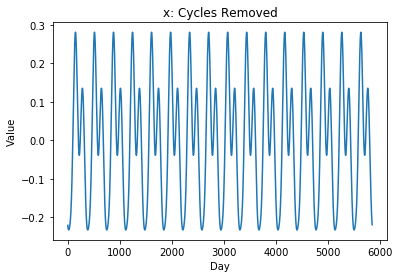

In [115]:
plt.plot(fitcycle_x)
plt.title('x: Cycles Removed')
plt.xlabel('Day')
plt.ylabel('Value')

Text(0.5, 1.0, 'x time series (adjusted)')

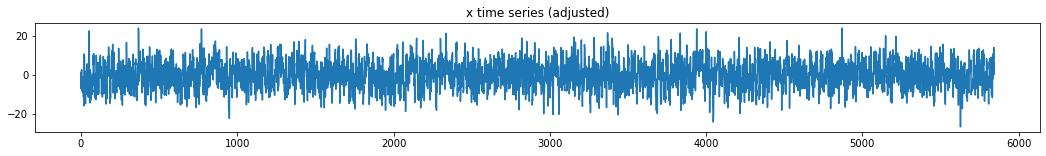

In [192]:
plt.subplots(figsize=(18,2))
plt.plot(x_norm)
plt.title('x time series (adjusted)')

Text(0.5, 1.0, 'y time series (adjusted)')

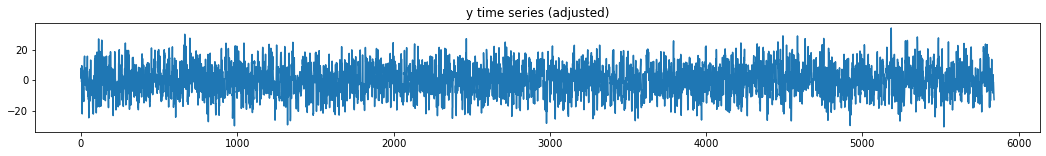

In [193]:
plt.subplots(figsize=(18,2))
plt.plot(y_norm)
plt.title('y time series (adjusted)')

## Using WOSA on each time series

In [116]:
fs = 1 # sampling frequency, determines nyquist max freq by fs/2
window = 'hann'
M = 2**7 #(128, always use power of two)#this is chunklength M)
noverlap = M // 2
df = np.floor(ndays/(M/2)*1.2)-1 # Nobs / Nspectralestimates=M/2; could multiple by 1-1.5 or 1.2 for hann window

wosa_x, Pxx_x = signal.welch(x_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

# wosa_xignore, Pspectrum_x = signal.welch(x_norm, fs=fs, window=window,
#                                nperseg=M, noverlap=noverlap,
#                                scaling='spectrum')

wosa_y, Pxx_y = signal.welch(y_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

# wosa_yignore, Pspectrum_y = signal.welch(x_norm, fs=fs, window=window,
#                                nperseg=M, noverlap=noverlap,
#                                scaling='spectrum')
print(df)

108.0


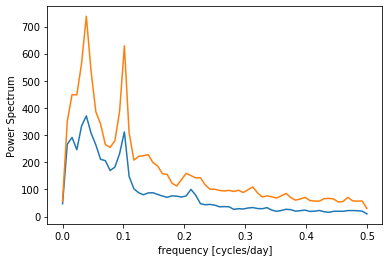

In [117]:
plt.plot(wosa_x, Pxx_x)
plt.plot(wosa_y, Pxx_y)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum')
plt.show()

In [118]:
1/wosa_x

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([         inf, 128.        ,  64.        ,  42.66666667,
        32.        ,  25.6       ,  21.33333333,  18.28571429,
        16.        ,  14.22222222,  12.8       ,  11.63636364,
        10.66666667,   9.84615385,   9.14285714,   8.53333333,
         8.        ,   7.52941176,   7.11111111,   6.73684211,
         6.4       ,   6.0952381 ,   5.81818182,   5.56521739,
         5.33333333,   5.12      ,   4.92307692,   4.74074074,
         4.57142857,   4.4137931 ,   4.26666667,   4.12903226,
         4.        ,   3.87878788,   3.76470588,   3.65714286,
         3.55555556,   3.45945946,   3.36842105,   3.28205128,
         3.2       ,   3.12195122,   3.04761905,   2.97674419,
         2.90909091,   2.84444444,   2.7826087 ,   2.72340426,
         2.66666667,   2.6122449 ,   2.56      ,   2.50980392,
         2.46153846,   2.41509434,   2.37037037,   2.32727273,
         2.28571429,   2.24561404,   2.20689655,   2.16949153,
         2.13333333,   2.09836066,   2.06451613,   2.03

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 5.89629765e-03,  2.11170686e-02,  4.64470620e-03, -9.12304559e-03,
        -9.69866367e-03,  5.38440937e-04,  4.69374261e-02,  1.22332205e-01,
         2.44771717e-01,  4.97171146e-01,  1.00000000e+00,  4.97171146e-01,
         2.44771717e-01,  1.22332205e-01,  4.69374261e-02,  5.38440937e-04,
        -9.69866367e-03, -9.12304559e-03,  4.64470620e-03,  2.11170686e-02,
         5.89629765e-03]),
 None)

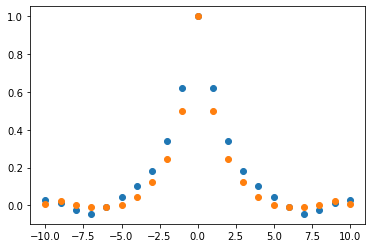

In [119]:
# plot autocorrelations for each
plt.acorr(x_norm,usevlines=False,maxlags=10)
plt.acorr(y_norm,usevlines=False,maxlags=10)
#plt.acorr?

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


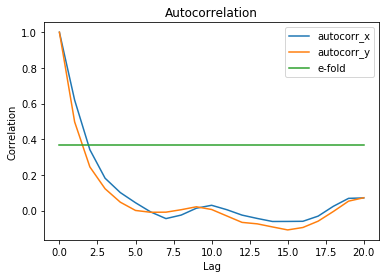

In [154]:
areg_x,conf_x = tsa.stattools.acf(x_norm,nlags=20,alpha=0.05)
areg_y,conf_y = tsa.stattools.acf(y_norm,nlags=20,alpha=0.05)

# hartmann barnes p121
# estimate autocorr for red noise by avg of one lag and sqrt of two lag
auto_x = (areg_x[1]+np.sqrt(areg_x[2]))/2
auto_y = (areg_y[1]+np.sqrt(areg_y[2]))/2
plt.plot(areg_x, label='autocorr_x')
plt.plot(areg_y, label='autocorr_y')
plt.plot(np.linspace(0,20,21),np.ones(len(areg_x))/np.exp(1), label='e-fold')
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

(0, 2)

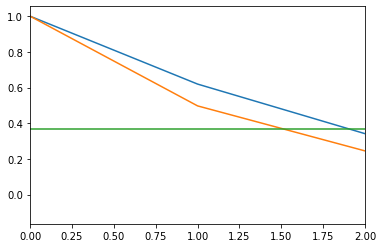

In [121]:
plt.plot(areg_x)
plt.plot(areg_y)
plt.plot(np.linspace(0,20,21),np.ones(len(areg_x))/np.exp(1))
plt.xlim(0,2)

In [122]:
print(auto_y, auto_x)

0.49595761943504557 0.601927639095727


In [196]:
# N*(deltaT)/(2*Tefold)
x_efold = 1.55
y_efold = 1.9

# really i should create separate autocorrs for each but saving time here
autocorr_df = ndays * fs / (2*y_efold) # keep things simple and use lesser df from y
autocorr_df += -1

print(ndays * fs / (2*x_efold),
      ndays * fs / (2*y_efold),
      autocorr_df)

1885.1612903225805 1537.8947368421054 1536.8947368421054


(0, 6)

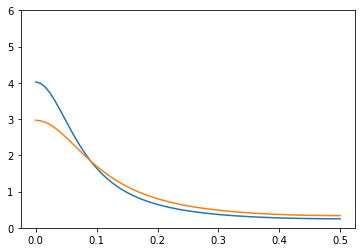

In [197]:
freq_dummy = np.linspace(0,np.pi,len(wosa_x)) # 129 dummy inputs but must go to pi, scale later
red_x = (1-auto_x**2)/(1-2*auto_x*np.cos(freq_dummy*1)+auto_x**2)
red_y = (1-auto_y**2)/(1-2*auto_y*np.cos(freq_dummy*1)+auto_y**2)
plt.plot(wosa_x,red_x)
plt.plot(wosa_x,red_y)
plt.ylim(0,6)

In [198]:
# this ratio works because i used same number of data points for red_x and wosa_x
# this shows up above in choice of freq_dummy
redadj_x = np.sum(Pxx_x)/np.sum(red_x)*red_x
redadj_y = np.sum(Pxx_y)/np.sum(red_y)*red_y

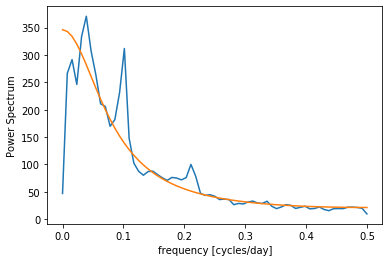

In [199]:
plt.plot(wosa_x, Pxx_x)
plt.plot(wosa_x, redadj_x)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum')
plt.show()

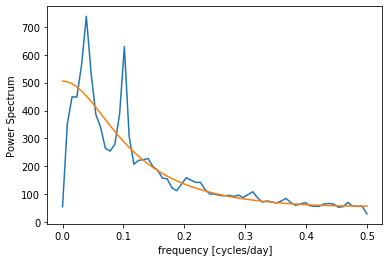

In [200]:
plt.plot(wosa_y, Pxx_y)
plt.plot(wosa_y, redadj_y)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum')
plt.show()

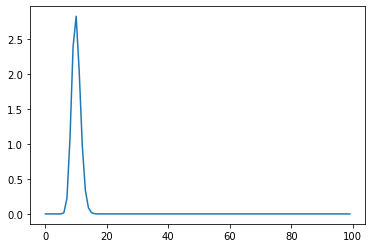

In [201]:
# check f distribution
#autocorr_df = ndays//2-1
plt.plot(stats.f.pdf(np.arange(0,10,.1),df,autocorr_df))

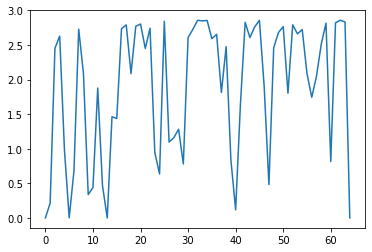

In [161]:
# check f stats for y and x
plt.plot(stats.f.pdf(Pxx_y/redadj_y,df,autocorr_df))

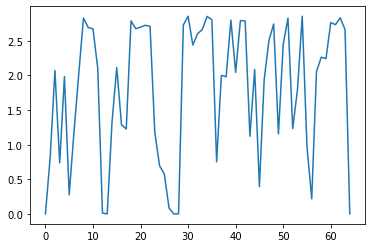

In [162]:
# check f stats for y and x
plt.plot(stats.f.pdf(Pxx_x/redadj_x,df,autocorr_df))

In [215]:
# find red noise line with 99% confidence interval
realconf = 0.99
clevel = realconf**(1.2/(M//2)) # confidence needed for each individual estimate to get realconf
conf = stats.f.ppf(clevel,df,autocorr_df) # f stat 
chanceoccurence = clevel**(M//2/1.2) # true a posteriori confidence level
print(conf, clevel, chanceoccurence)

1.5883250652439291 0.9998115739571639 0.9899999999999978


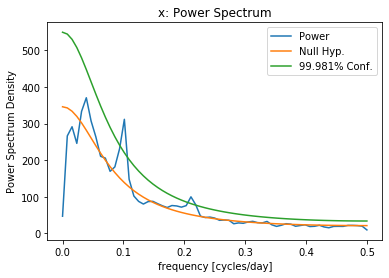

In [216]:
# plot with confidence interval
plt.plot(wosa_x, Pxx_x, label='Power')
plt.plot(wosa_x, redadj_x, label='Null Hyp.')
plt.plot(wosa_x,redadj_x*conf, label='99.981% Conf.')
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('x: Power Spectrum')
plt.legend()
plt.show()

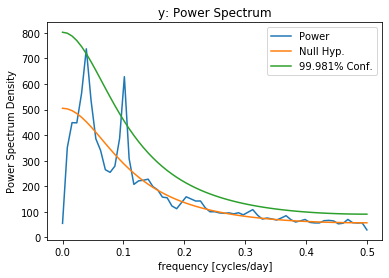

In [217]:
plt.plot(wosa_y, Pxx_y, label='Power')
plt.plot(wosa_y, redadj_y, label='Null Hyp.')
plt.plot(wosa_y,redadj_y*conf, label='99.981% Conf.')
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('y: Power Spectrum')
plt.legend()
plt.show()

(0, 0.125)

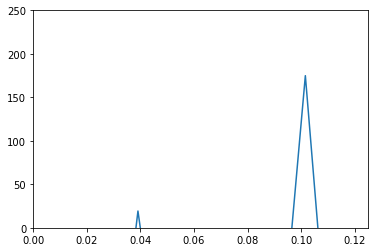

In [218]:
# y significant peaks
plt.plot(wosa_y,Pxx_y-redadj_y*conf)
plt.ylim(0,250)
plt.xlim(0,.125)

(0.04, 0.225)

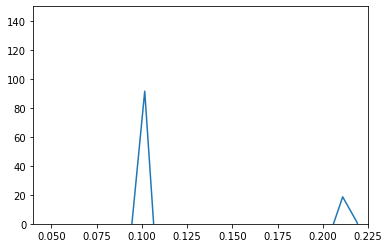

In [219]:
# x significant peaks
plt.plot(wosa_x,Pxx_x-redadj_x*conf)
plt.ylim(0,150)
plt.xlim(0.040,.225)

## Cross Spectrum

In [220]:
# Cross spectral density
csd_f, Pxy = signal.csd(x_norm, y_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')
csd_f, Pyx = signal.csd(y_norm, x_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


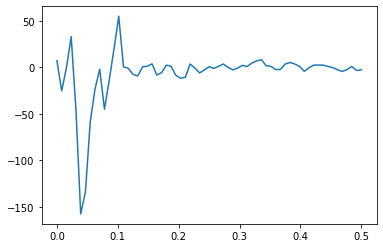

In [221]:
plt.plot(csd_f,Pxy)

Text(0, 0.5, 'Phase Difference [degrees]')

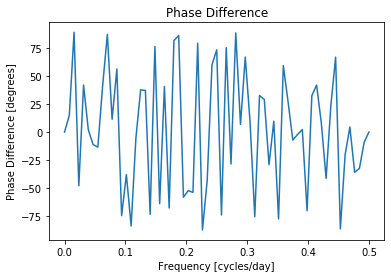

In [202]:
theta = np.arctan(np.imag(Pxy)/np.real(Pxy))
plt.plot(csd_f,np.rad2deg(theta))
plt.title('Phase Difference')
plt.xlabel('Frequency [cycles/day]')
plt.ylabel('Phase Difference [degrees]')

#theta_y = np.arctan(np.imag(Pyx)/np.real(Pyx))
#plt.plot(csd_f,np.rad2deg(theta_y))

In [141]:
np.angle(Pxy)

array([ 0.        , -2.88133207, -1.5916983 , -0.8314685 , -2.41167567,
       -3.1057451 ,  2.94832361,  2.90738671, -2.43113816, -1.62525197,
       -2.94134706, -2.16118664, -1.29702814, -0.65976346, -1.45725006,
        3.04494212, -2.48556828, -2.49482213, -1.27613492,  1.32928421,
       -1.11090914, -2.43297475,  1.96285131,  1.42037442,  1.49829663,
        2.13042755,  2.23258526,  2.20524288,  1.38072202,  1.62306878,
        2.39463903, -2.09975111,  1.27680465,  1.85509319,  1.31014589,
       -0.49593397, -1.60165989, -3.02251406, -1.97629471,  0.16795654,
       -1.31376359,  0.56783644,  0.50655473, -0.50545942,  0.16972061,
       -1.3484522 , -2.10785155, -2.6697947 , -0.12367212, -0.03655735,
        0.03989428, -1.2213704 , -2.57754272, -2.4114791 ,  0.13715172,
       -0.7184653 ,  0.41567729,  1.16359664,  1.64002229,  2.79119888,
       -3.06293405,  2.51822342, -0.5647077 ,  2.98287374,  3.14159265])

In [180]:
# Coherence
coh_f, Cxy = signal.coherence(x_norm, y_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap)
coh_f, Cyx = signal.coherence(y_norm, x_norm, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap)

Text(0, 0.5, 'Coherence Squared')

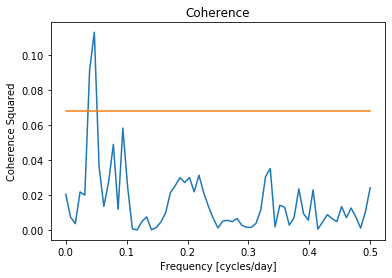

In [203]:
#critical coherence
coh_crit = 0.068 # from p134 dennis book based on 99.9% confidence
plt.plot(coh_f,Cxy,label='Coherence')
plt.plot(coh_f,np.zeros(len(coh_f))+coh_crit,label='Critical Value')
plt.title('Coherence')
plt.xlabel('Frequency [cycles/day]')
plt.ylabel('Coherence Squared')

In [207]:
np.where(Cxy==Cxy.max())
print(Cxy[6], csd_f[6])

0.1128826005966258 0.046875


In [187]:
print(np.rad2deg(theta[6]))
print(theta[6])
#theta[5]
theta_y[6]

-11.073500428098583
-0.19326904219132188


0.19326904219132188

In [87]:
theta[6]

-0.19326904219132188

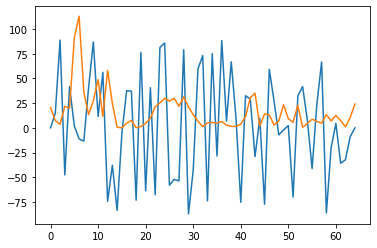

In [88]:
plt.plot(np.rad2deg(theta))
plt.plot(Cxy*10e2)

### ex. from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

In [89]:
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

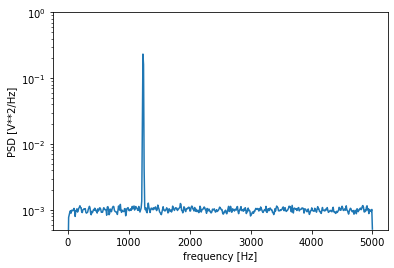

In [90]:
f, Pxx_den = signal.welch(x, fs,window='hann', nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
testx = np.arange(0,2048)
testcos = np.cos(2*np.pi/4.2*testx)
plt.plot(testcos[0::4])
plt.xlim(0,100)

In [ ]:
f, Pxx_den = signal.welch(testcos, fs=6, window='hann', nperseg=64,scaling='density')
plt.semilogy(f, Pxx_den)

In [ ]:
test2 = np.arange(0,100,0.01)

In [ ]:
ytest2 = np.cos(test2)

In [ ]:
f, Pxx_den = signal.welch(ytest2, fs=1, window='hann', nperseg=256,scaling='density')
plt.plot(f, Pxx_den)
plt.xlim(0,0.025)

In [ ]:
np.trapz(Pxx_den,f)

In [ ]:
stats.f.

In [ ]:
plt.plot(stats.f.ppf(0.95,df,ndays/2)*redadj_y)